# Analyse von Textdaten mit NLTK und Gensim

Wir wollen uns die Analyse von Textdaten aus unserem vorbereiteten Datensatz anhand einer etwas komplexeren Analysefrage ansehen: "Topic Modelling" - die Identifikation und Gruppierung von thematisch ähnlichen Texten.

In [1]:
# pandas importieren
import pandas as pd
# seaborn importieren
import seaborn as sns
# matplotlib importieren
import matplotlib.pyplot as plt
# NLTK importieren
import nltk

# Import und Initialisierung von bia-bob
from bia_bob import bob
# API Key wird aus condas Umgebungsvariable gelesen
bob.initialize(endpoint='blablador', model='alias-fast')

## Vorbereitungen

In [2]:
# Individuellen NLTK Download-Ordner angeben
nltk.data.path.append('/Users/matthias/.cache/nltk_data')
# Potenziell doppelte Einträge entfernen
nltk.data.path = list(set(nltk.data.path))

Laden des vorbereiteten Datensatzes ohne Fehlwerte.

In [3]:
df_prep = pd.read_csv('../data/news_category_data_prep.csv', sep='|', parse_dates=[5])

In [4]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061 entries, 0 to 5060
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   link               5061 non-null   object        
 1   headline           5061 non-null   object        
 2   category           5061 non-null   object        
 3   short_description  5061 non-null   object        
 4   authors            5061 non-null   object        
 5   date               5061 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 237.4+ KB


## Ablauf der Analyse

Die gewünschte Analyse scheint zunächst ziemlich komplex zu sein. Bitten wir doch zunächst unseren KI-Assistenten, den Vorgang in einzelne Schritte zu zerlegen und diese zu erläutern

In [7]:
%%bob
Für den DataFrame mit den Spalten {df_prep.columns} möchte ich Texte aus der Spalte short_description nach ähnlichen Themen gruppieren (Topic Modelling). 
Dazu sollen NLTK und Gensim genutzt werden.
Erkläre mir die notwendigen Schritte, KEIN Code, antworte in DEUTSCH.

 Natürlich! Hier sind die notwendigen Schritte, um Texte aus der Spalte `short_description` nach ähnlichen Themen zu gruppieren (Topic Modelling) mit NLTK und Gensim:

1. **Datenvorverarbeitung**:
   - **Textreinigung**: Entferne Sonderzeichen, Zahlen, und andere irrelevante Informationen aus den Texten.
   - **Tokenisierung**: Teile die Texte in Wörter (Tokens) auf.
   - **Stoppwort-Entfernung**: Entferne häufig vorkommende und uninteressante Wörter wie "und", "die", etc.
   - **Stemming/lemma**: Reduziere Wörter auf ihre Grundformen (Stem). Dies hilft, verschiedene Formen desselben Wortes als gleich zu behandeln.

2. **Datenvorbereitung**:
   - **Bag-of-Words (BoW)**: Erstelle ein BoW-Modell, um die Häufigkeit der Wörter in den Texten zu erfassen.
   - **TF-IDF**: Berechne die Term Frequency-Inverse Document Frequency (TF-IDF), um die Relevanz der Wörter in den Texten zu bestimmen.

3. **Modellierung**:
   - **LDA (Latent Dirichlet Allocation)**: Trainiere ein LDA-Modell, um Themen in den Texten zu identifizieren. LDA ist ein probabilistisches Modell, das die Themen in den Texten als verteilte Themenansammlungen beschreibt.

4. **Visualisierung**:
   - **PyLDAvis**: Verwende PyLDAvis, um die Themen und deren Wortverteilungen visuelle darzustellen. Dies hilft, die Themen besser zu verstehen und zu interpretieren.

5. **Interpretation**:
   - **Themenanalyse**: Analysiere die ermittelten Themen und ihre Wortverteilungen, um ein besseres Verständnis der Daten zu gewinnen.

6. **Anwendung**:
   - **Kategorisierung**: Verwende die ermittelten Themen, um die Texte in den entsprechenden Kategorien zu klassifizieren. Dies kann helfen, die Daten besser zu organisieren und zu analysieren.

Diese Schritte helfen dir, die Texte aus der Spalte `short_description` nach ähnlichen Themen zu gruppieren und eine tiefere Einblicke in die Daten zu gewinnen.

### Vorverarbeitung

Es ist sinnvoll, die Ergebnisse der Vorverarbeitung mit in den DataFrame einzufügen und dies abschließend als Zwischenergebnis zu speichern. Bei sehr großen Datenmengen muss dieser Schritt dann nicht ständig wiederholt werden. Für die Vorverarbeitung wollen wir eine Python-Funktion definieren, die Tokenization, Stopword removal und Stemming übernimmt. 

Statt einfaches Stemming nutzen wir aber Lemmatization, hierbei wird sowohl die Wortart (Verb, Substantiv, etc) - [auch Part-of-Speech (POS)](https://www.nltk.org/book/ch05.html) - als auch der Kontext einbezogen. Hierfür wählen wir NLTKs [WordNetLemmatizer](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html), bei [WordNet](https://www.nltk.org/api/nltk.corpus.reader.wordnet.html) handelt es ich um eine umfangreiche lexikalische Datenbank. Wir definieren eine weitere Funktion welche für eine Liste von Token deren Lemma erstellt.

In [5]:
# Imports für Lemmatization
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Funktion zur Abbildung des POS (part of speech) von NLTK zu WordNet
def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Funktion für Lemmatization
def lemmatize_tokens(tokens):
    # Ermitteln des POS je Token
    pos_tags = pos_tag(tokens)
    # Erstellen der Lemma je Token
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos)) for (token, pos) in pos_tags]
    return lemmatized_tokens

In [6]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
eng_stop_words = set(stopwords.words('english'))

# Funktion zu Vorverarbeitung eines Dokuments / Beitrages
def nltk_preprocess(doc):
    tokens = word_tokenize(doc)
    # TODO: Satzzeichen entfernen
    # TODO: Stopword removal
    lemmatized_tokens = lemmatize_tokens(tokens)
    return lemmatized_tokens

Die jetzt definierte Funktion für die Vorverarbeitung können wir auf die Spalte `short_description` anwenden und das Ergebnis in eine neue Spalte `description_tokens` schreiben. Hierfür gibt es mehrere Möglichkeiten. Eine davon ist pandas' Methode [`apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), welche eine Funktion auf einen DataFrame oder eine einzelne Spalte anwendet.

In [7]:
# Besser auf Kopie des originalen DataFrame arbeiten
df = df_prep.copy()

In [8]:
# df['description_tokens'] = ...

In [9]:
# df.to_csv(...)

### Corpus und Bag of Words

In [10]:
df = pd.read_csv('../data/news_category_data_tokens.csv', sep='|', parse_dates=[5], converters={'description_tokens': pd.eval})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061 entries, 0 to 5060
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   link                5061 non-null   object        
 1   headline            5061 non-null   object        
 2   category            5061 non-null   object        
 3   short_description   5061 non-null   object        
 4   authors             5061 non-null   object        
 5   date                5061 non-null   datetime64[ns]
 6   description_tokens  5061 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 276.9+ KB


In [11]:
df.head()

link  \
0  https://www.huffpost.com/entry/lindsey-graham-...   
1  https://www.huffpost.com/entry/tweets-cats-wat...   
2  https://www.huffpost.com/entry/ken-jennings-ap...   
3  https://www.huffpost.com/entry/biden-coronavir...   
4  https://www.huffpost.com/entry/trick-to-keepin...   

                                            headline       category  \
0  Lindsey Graham Calls For Stand-Alone Vote On $...       POLITICS   
1  24 Tweets About Cats Who Want To Watch The Wor...         COMEDY   
2  Ken Jennings Apologizes For 'Unartful And Inse...  ENTERTAINMENT   
3  Biden To Host Inauguration Eve Memorial To Liv...       POLITICS   
4  The Simple, Science-Backed Trick To Keeping Yo...       WELLNESS   

                                   short_description            authors  \
0  The Republican senator broke with Senate Major...      Hayley Miller   
1                      We are all cats as 2020 ends.      Elyse Wanshel   
2  The "Jeopardy" champion shared a series of ref...     Jenna Amatulli   
3  A ceremony around the Lincoln Memorial to reme...       Sara Boboltz   
4  A new study may have cracked the code to what ...  Catherine Pearson   

        date                                 description_tokens  
0 2020-12-31  [republican, senator, break, senate, majority,...  
1 2020-12-31                                   [cat, 2020, end]  
2 2020-12-31  [jeopardy, champion, share, series, reflective...  
3 2020-12-31  [ceremony, around, lincoln, memorial, remember...  
4 2020-12-31  [new, study, may, crack, code, make, people, s...

In [12]:
from gensim import corpora

# Erstellen eines Gensim-Dictionaries aus den Token-Listen
dictionary = corpora.Dictionary(df['description_tokens'])

# Erstellen eines Corpus mit BOW aus den Token-Listen
corpus_bow = [dictionary.doc2bow(token_list) for token_list in df['description_tokens']]
# Dient der Initialisierung des Dictionary
temp = dictionary[0]

In [13]:
print('Eindeutige Token im Corpus: ', len(dictionary))
print('Beispiel ID zu Token: ', dictionary.id2token[1])
print('Anzahl der Dokumente: ', len(corpus_bow))

Eindeutige Token im Corpus:  11668
Beispiel ID zu Token:  bipartisan
Anzahl der Dokumente:  5061


### Topic Modelling mit Gensims Latent Dirichlet Allocation (LDA)

Bei LDA wir davon ausgegangen, dass jedes Dokument eine Mischung aus verschiedenen Themen (Topics) enthält, wobei jedes Wort des Dokuments einem bestimmten Thema zugeordnet werden kann. Daraus wird die Themenverteilung für jedes Dokument und die Wortverteilung für jede Thema abgeleitet, was die Identifizierung von Themen innerhalb des Dokumentenkorpus ermöglicht. LDA setzt dabei die Angabe der Anzahl der zu erwartenden Themen voraus - hier ist entsprechendes Domänenwissen von Vorteil, zusätzlich muss etwas experimentiert werden.

In [14]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

# Training eines LDA Modells mit den folgenden Parametern
num_topics = 7   # Anzahl der Themen
chunksize = 6000  # Wie viele Dokumente sollen pro Trainingsdurchlauf verarbeitet werden
passes = 20       # Wie oft soll LDA auf allen Dokumenten traininert werden
iterations = 500  # Wie oft soll ein einzelnes Dokument verarbeitet werden

lda_model = LdaModel(
    corpus=corpus_bow,
    id2word=dictionary.id2token,
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes
)
# Ausgabe eines beispielhaften Topics mit seinen wichtigsten Wörtern
top_topics = lda_model.top_topics(corpus_bow)
print('\nTopic Beispiel mit Coherence')
pprint(top_topics[0])


Topic Beispiel mit Coherence
([(0.014930628, 'say'),
  (0.0071319486, 'president'),
  (0.005374807, 'new'),
  (0.0046553076, 'get'),
  (0.0046460866, 'host'),
  (0.004477379, 'former'),
  (0.0044398145, 'show'),
  (0.003925082, 'covid19'),
  (0.0039028414, 'people'),
  (0.0036975893, 'make'),
  (0.0036569482, 'trump'),
  (0.0034744227, 'house'),
  (0.003461224, 'state'),
  (0.0033603464, 'news'),
  (0.003242009, 'face'),
  (0.0031774035, 'year'),
  (0.0031720225, 'actor'),
  (0.0029721675, 'court'),
  (0.0028926672, 'come'),
  (0.0028394402, 'us')],
 -4.104641119349129)


### Auswertung und Visualisierung

Um die Qualität eines LDA Modells einschätzen zu können, bietet Gensim z.b. den CoherenceScore. Dieser Wert für ein Thema soll messen, wie „sinnvoll“ oder „kohärent“ die wichtigsten Wörter in einem Thema sind. Wenn Gensim einen Kohärenzwert für ein LDA-Modell ausgibt, misst es, wie gut die Wörter in jedem Thema in einem semantischen Sinn tatsächlich zusammenpassen. Je höher dieser Wert, desto besser.

In [15]:
# Berechnung des CoherenceScore und Ausgabe
c_model = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
print('\nDurchschnittliche Coherence: %.4f.' % c_model.get_coherence())


Durchschnittliche Coherence: -4.6761.


In [17]:
print('Coherence pro Thema')
pprint(c_model.get_coherence_per_topic())

Coherence pro Thema
[-4.273176905957267,
 -5.307324202875253,
 -5.106546221020059,
 -4.431687532119975,
 -4.7310839464503065,
 -4.598641185570053,
 -4.283958574314123]


Für die Auswertung der errechneten Tehmenzugehörigkeiten gehen wir den bisherigen Weg quasi zurück. Wir berechnen für jeden Eintrag in unserem Datensatz auf Basis der vorverarbeiteten Token den zugehörigen Bag-of-Word Vektor. Dieser kann dann genutzt werden, um jedem Eintrag eine Liste von Themen zuzuordnen.

In [18]:
df_lda = df.copy()

In [19]:
# BOW für jeden Eintrag im DataFrame
df_lda['bow'] = df['description_tokens'].apply(dictionary.doc2bow)

In [20]:
df_lda[['short_description', 'description_tokens', 'bow']].head(10)

short_description  \
0  The Republican senator broke with Senate Major...   
1                      We are all cats as 2020 ends.   
2  The "Jeopardy" champion shared a series of ref...   
3  A ceremony around the Lincoln Memorial to reme...   
4  A new study may have cracked the code to what ...   
5  Here's how to protect your mental health so yo...   
6  Trump has schemed to exclude people from the c...   
7  "Today is the tomorrow you were so worried abo...   
8  An inspiration for "manly men" and everyone el...   
9  A lack of Trump administration planning has pu...   

                                  description_tokens  \
0  [republican, senator, break, senate, majority,...   
1                                   [cat, 2020, end]   
2  [jeopardy, champion, share, series, reflective...   
3  [ceremony, around, lincoln, memorial, remember...   
4  [new, study, may, crack, code, make, people, s...   
5  [heres, protect, mental, health, even, slightl...   
6  [trump, scheme, exclude, people, census, count...   
7  [today, tomorrow, worry, yesterday, hopkins, s...   
8          [inspiration, manly, men, everyone, else]   
9  [lack, trump, administration, planning, put, b...   

                                                 bow  
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...  
1                        [(16, 1), (17, 1), (18, 1)]  
2  [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), ...  
3  [(35, 1), (36, 1), (37, 1), (38, 1), (39, 1), ...  
4  [(45, 1), (46, 1), (47, 1), (48, 1), (49, 1), ...  
5  [(34, 1), (56, 1), (57, 1), (58, 1), (59, 1), ...  
6  [(51, 1), (66, 1), (67, 1), (68, 1), (69, 1), ...  
7  [(29, 1), (51, 1), (73, 1), (74, 1), (75, 1), ...  
8      [(81, 1), (82, 1), (83, 1), (84, 1), (85, 1)]  
9  [(72, 1), (86, 1), (87, 1), (88, 1), (89, 1), ...

In [21]:
# Funktion, um mithilfe des trainierten LDA Modells bei ANgabe eines BOW die zugehörigen Topics als Liste zu erhalten
# minimum_probability gibt an, wie hoch die Wahrscheinlichkeit der Zuordnung mindestens sein soll
def extract_document_topics(bow, minimum_probability=0.2):
    topics = lda_model.get_document_topics(bow, minimum_probability=minimum_probability)
    return [t for t,p in (topic for topic in topics)]

In [22]:
df_lda['topics'] = df_lda['bow'].apply(extract_document_topics)

In [23]:
df_lda[['short_description', 'topics']].head(10)

short_description  topics
0  The Republican senator broke with Senate Major...     [3]
1                      We are all cats as 2020 ends.     [3]
2  The "Jeopardy" champion shared a series of ref...     [2]
3  A ceremony around the Lincoln Memorial to reme...  [0, 4]
4  A new study may have cracked the code to what ...     [2]
5  Here's how to protect your mental health so yo...     [5]
6  Trump has schemed to exclude people from the c...     [4]
7  "Today is the tomorrow you were so worried abo...     [5]
8  An inspiration for "manly men" and everyone el...     [1]
9  A lack of Trump administration planning has pu...     [3]

Die Themen können wir mit einer sogenannten Wordcloud visualisieren. Hierbei erschienen häufige Wörter größer, seltene Wörter kleiner. Je Thema sammeln wir also die Wörter aus den zugehörigen Einträgen im DataFrame und stellen diese als Wordcloud dar.

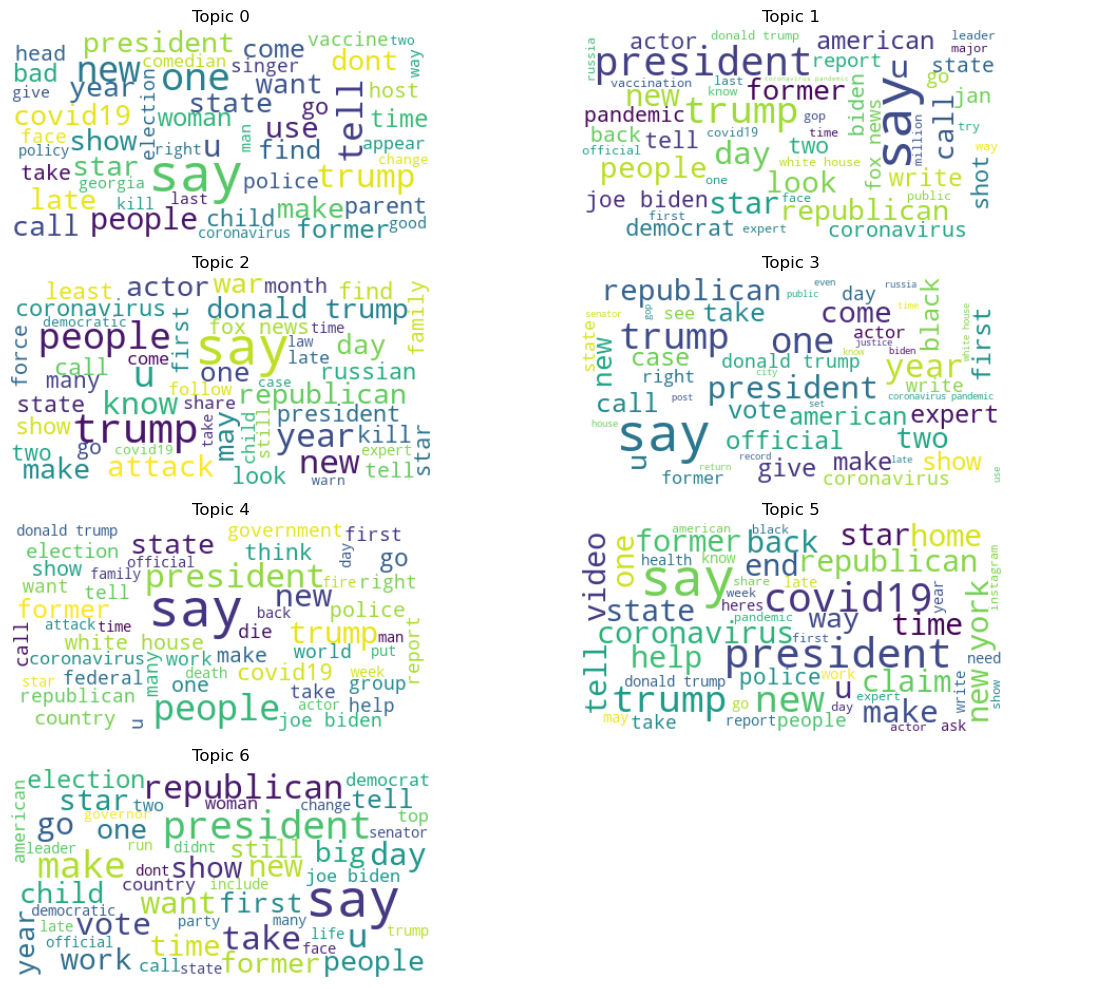

In [24]:
import math
from wordcloud import WordCloud

# Generiere Subplots für Darstellung in 2 Spalten
nrows = math.ceil(num_topics / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for topic_id in range(num_topics):
    # Einträge mit Topic identifizieren und Zeilen-Indices auswählen
    doc_indices = df_lda.index[df_lda['topics'].apply(lambda topics: topic_id in topics)]
    # Alle Token je Topic sammeln
    tokens_for_topic = []
    for idx in doc_indices:
        tokens_for_topic.extend(df_lda.loc[idx, 'description_tokens'])

    # Tokenliste in einen String zusammenführen
    text_for_topic = " ".join(tokens_for_topic)

    # WordCloud für Topic generieren
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color='white').generate(text_for_topic)

    # WordCloud in separatem Subplot darstellen
    ax = axes[topic_id]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Topic {topic_id}")
    ax.axis("off")

# Leere Subplots bei ungerader Anzahl verstecken
for i in range(num_topics, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show() 

## Weitere Verarbeitungs- und Analysemöglichkeiten mit NLTK und Gensim

Neben der gezeigten LDA Analyse bieten NLTK und Gensim zahlreiche weitere Möglichkeiten, z.B.
* [Named-Entity Recognition mit NLTK](https://www.nltk.org/book/ch07.html#sec-ner) (Erkennen von Eigennamen in Texten) via [nltk.ne_chunk](https://www.nltk.org/api/nltk.chunk.ne_chunk.html)
* Erstellen von Wort- und Dokument-Embeddings mit Gensim via [models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html) und [models.doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)

Es lohnt sich ein Blick in die jeweiligen Dokumentation, z.B.
* [NLTK Book](https://www.nltk.org/book/)
* [Gensim API Reference](https://radimrehurek.com/gensim/apiref.html)